In [1]:
##############################################################################
# blosc2_grok: Grok (JPEG2000 codec) plugin for Blosc2
#
# Copyright (c) 2023  The Blosc Development Team <blosc@blosc.org>
# https://blosc.org
# License: GNU Affero General Public License v3.0 (see LICENSE.txt)
##############################################################################

"""
Benchmark for compressing blocked images with grok codec.

Data can be downloaded from: http://www.silx.org/pub/nabu/data/compression/lung_raw_2000-2100.h5
"""

'\nBenchmark for compressing blocked images with grok codec.\n\nData can be downloaded from: http://www.silx.org/pub/nabu/data/compression/lung_raw_2000-2100.h5\n'

In [2]:
import h5py
import blosc2
import blosc2_grok
import numpy as np
import hdf5plugin
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time

In [3]:
# Params for the frame iterator
verbose = False
all_frames = False
meas = {}  # dictionary for storing the measurements
nblocks = 4  # number of blocks per dimension, when blocked

In [4]:
# Register grok codec locally
blosc2.register_codec('grok', 160)

In [5]:
# Open the dataset
data_dir = '/Users/faltet/Downloads/'
f = h5py.File(f'{data_dir}/lung_raw_2000-2100.h5', 'r')
dset = f['/data']
if all_frames:
    nframes = dset.shape[0]
else:
    nframes = 1
images_per_chunk = 16
chunks = (images_per_chunk, dset.shape[1], dset.shape[2])
print(f"Compressing dataset of {dset.shape} images ...")

Compressing dataset of (100, 1024, 2048) images ...


In [6]:
# Define the compression and decompression parameters for Blosc2.
# Disable the filters and the splitmode, because these don't work with grok.
cparams = {
    'codec': 160,
    #'nthreads': 16,  # when commented out, this is automatically set to the number of cores
    'filters': [],
    'splitmode': blosc2.SplitMode.NEVER_SPLIT,
}
dparams = {
    'nthreads': 4,
}

# Set the default parameters that will be used by grok
grok_params = {
    'cod_format': blosc2_grok.GrkFileFmt.GRK_FMT_JP2,
    'num_threads': 0,
}

In [7]:
for blocked in (False, True):
    if blocked:
        print("Compressing blocked images ...")
        blocks = (1, dset.shape[1] // nblocks, dset.shape[2] // nblocks)
    else:
        print("Compressing non-blocked images ...")
        blocks = (1, dset.shape[1], dset.shape[2])
    # Compress the dataset with different compression ratios
    quality_mode = "rates-blocked" if blocked else "rates-nonblocked"
    print(f"Quality mode: {quality_mode}")
    ssims = []
    cratios = []
    times = []
    range_vals = list(range(1, 11))
    range_vals_str = "range(1, 11)"
    for cratio in range_vals:
        if verbose:
            print(f"Compressing with cratio={cratio}x ...")
        blosc2_grok.set_params_defaults(
            quality_mode=quality_mode.split("-")[0],
            quality_layers=np.array([cratio], dtype=np.float64),
            **grok_params)
    
        # Iterate over the frames
        iter_frames = tqdm(range(nframes)) if verbose else range(nframes)
        for i in iter_frames:
            im = dset[i:i+images_per_chunk, ...]
            # Transform the numpy array to a blosc2 array. This is where compression happens.
            t0 = time()
            b2im = blosc2.asarray(im, chunks=chunks, blocks=blocks, cparams=cparams)
            if i == 0:
                times.append(time() - t0)
                cratios.append(b2im.schunk.cratio)
                # Compare with the original image
                im2 = b2im[:]
                ssim_ = ssim(im[0], im2[0], data_range=im.max() - im.min())
                ssims.append(ssim_)
        if verbose:
            print(f"SSIM: {ssim_}")
    meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times}

Compressing non-blocked images ...
Quality mode: rates-nonblocked
Compressing blocked images ...
Quality mode: rates-blocked


In [8]:
#meas

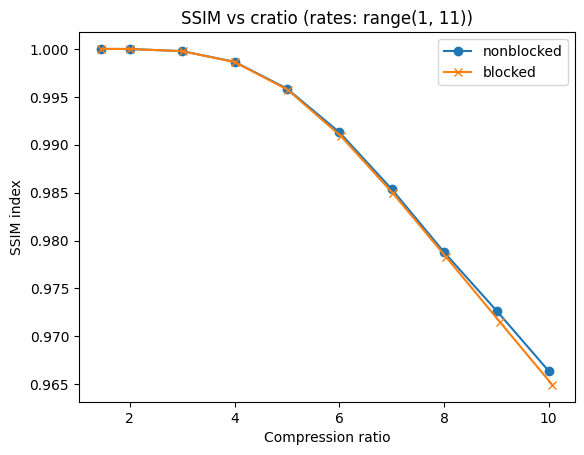

In [9]:
for blocked in (False, True):
    quality_mode = "rates-blocked" if blocked else "rates-nonblocked"
    marker = 'x-' if blocked else 'o-'
    label = quality_mode.split("-")[1]
    plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], marker, label=label)
plt.title(f'SSIM vs cratio ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')
plt.legend()

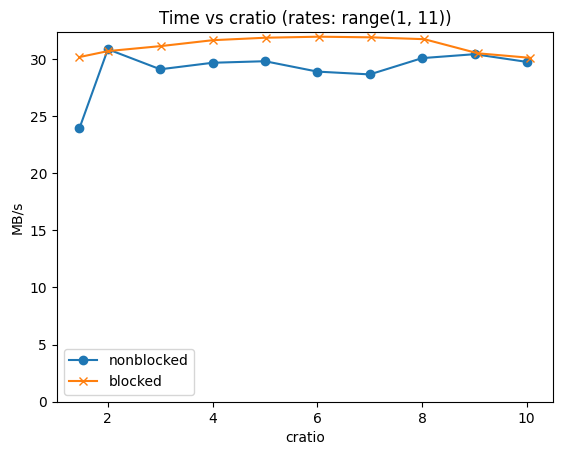

In [10]:
sizeMB = np.prod(chunks) / 2**20
for blocked in (False, True):
    quality_mode = "rates-blocked" if blocked else "rates-nonblocked"
    marker = 'x-' if blocked else 'o-'
    label = quality_mode.split("-")[1]
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['times'], marker, label=label)
plt.title(f'Time vs cratio ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('cratio')
plt.ylabel('MB/s')
plt.ylim(0)
plt.legend()

In [11]:
for blocked in (False, True):
    if blocked:
        print("Compressing blocked images ...")
        blocks = (1, dset.shape[1] // nblocks, dset.shape[2] // nblocks)
    else:
        print("Compressing non-blocked images ...")
        blocks = (1, dset.shape[1], dset.shape[2])
    # Compress the dataset with different SNR ratios
    quality_mode = "dB-blocked" if blocked else "dB-nonblocked"
    print(f"Quality mode: {quality_mode}")
    ssims = []
    cratios = []
    times = []
    range_vals = list(range(90, 45, -5))
    range_vals_str = "range(90, 45, -5)"
    for quality in range_vals:
        if verbose:
            print(f"Compressing with quality={quality}dB ...")
        blosc2_grok.set_params_defaults(
            quality_mode=quality_mode.split("-")[0],
            quality_layers=np.array([quality], dtype=np.float64),
            **grok_params)
    
        # Iterate over the frames
        iter_frames = tqdm(range(nframes)) if verbose else range(nframes)
        for i in iter_frames:
            im = dset[i:i + images_per_chunk, ...]
            # Transform the numpy array to a blosc2 array. This is where compression happens.
            t0 = time()
            b2im = blosc2.asarray(im, chunks=chunks, blocks=blocks, cparams=cparams)
            if i == 0:
                times.append(time() - t0)
                cratios.append(b2im.schunk.cratio)
                # Compare with the original image
                im2 = b2im[:]
                ssim_ = ssim(im[0], im2[0], data_range=im.max() - im.min())
                ssims.append(ssim_)
        if verbose:
            print(f"SSIM: {ssim_}")
    meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times}

Compressing non-blocked images ...
Quality mode: dB-nonblocked
Compressing blocked images ...
Quality mode: dB-blocked


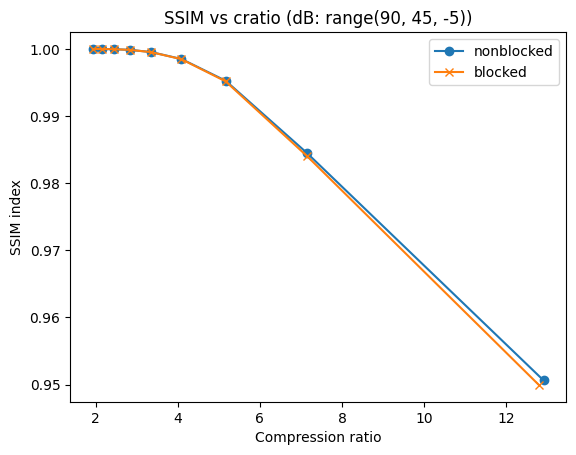

In [12]:
for blocked in (False, True):
    quality_mode = "dB-blocked" if blocked else "dB-nonblocked"
    marker = 'x-' if blocked else 'o-'
    label = quality_mode.split("-")[1]
    plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], marker, label=label)
plt.title(f'SSIM vs cratio ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')
plt.legend()

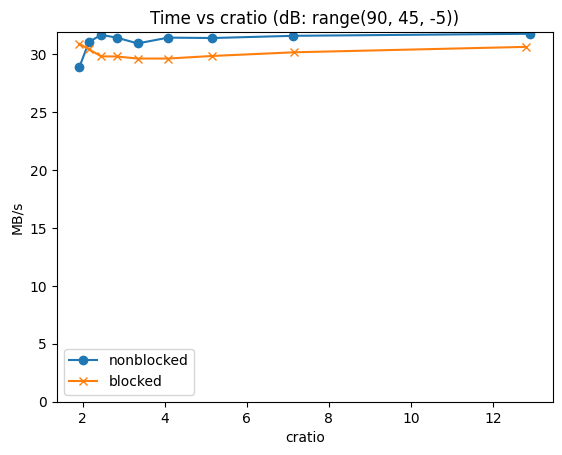

In [13]:
sizeMB = np.prod(chunks) / 2**20
for blocked in (False, True):
    quality_mode = "dB-blocked" if blocked else "dB-nonblocked"
    marker = 'x-' if blocked else 'o-'
    label = quality_mode.split("-")[1]
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['times'], marker, label=label)
plt.title(f'Time vs cratio ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('cratio')
plt.ylabel('MB/s')
plt.ylim(0)
plt.legend()